In [8]:
# This is a code sample of the movies dataset analysis. Cleaning and comparing imdb dataset with a resulting file from one of the machine learning models 
#  I developed  in one of my projects. 
# Import libraries
import pandas as pd
import seaborn as sns

# Read IMDB dataframe and filter out movies
imdb_df = pd.read_csv("title.basics.tsv",sep='\t',low_memory=False)
imdb_df = imdb_df.query('titleType == "movie"')

# Print length of IMDB csv
print("Length of IMDB csv: ", len(imdb_df))

# Read and filter test dataframe
test_df = pd.read_csv("genre_predictions_05_08_2022.csv")
test_df = test_df.query('content_type == "Movie"')

# Print length of test csv
print("Length of test csv: ", len(test_df))

# Remove leading/trailing whitespaces and convert everything to lowercase for ease of use and matching
test_df = test_df.applymap(lambda s: s.strip().lower() if type(s) == str else s)
imdb_df = imdb_df.applymap(lambda s: s.strip().lower() if type(s) == str else s)

# Merge dataframes based on show name
df_matched = pd.merge(test_df, imdb_df , left_on='show_name', right_on='primaryTitle')
df_matched = df_matched.drop_duplicates()

# Remove '\n' from Genre
df_matched = df_matched.replace('\n','', regex=True)
df_matched = df_matched.replace(r'\\n','', regex=True)

# Split genres into multiple columns, strip whitespaces, and convert everything to lowercase
df_matched[['imdb_genre1', 'imdb_genre2', 'imdb_genre3']] = df_matched['genres'].str.split(',', expand=True)
df_matched[['sub_genre1', 'sub_genre2']] = df_matched['sub_genres'].str.split(',', expand=True)

df_matched['imdb_genre1'] = df_matched['imdb_genre1'].str.strip()
df_matched['imdb_genre2'] = df_matched['imdb_genre2'].str.strip()
df_matched['imdb_genre3'] = df_matched['imdb_genre3'].str.strip()
df_matched['sub_genre1'] = df_matched['sub_genre1'].str.strip()
df_matched['sub_genre2'] = df_matched['sub_genre2'].str.strip()
df_matched['genre'] = df_matched['genre'].str.strip()
df_matched['corr_genre'] = df_matched['corr_genre'].str.strip()

# Replace genres based on training labels
dict_replace = {'sci-fi & fantasy': 'science fiction',
                'sci-fi': 'science fiction',
                'mystery': 'science fiction',
                'fantasy': 'science fiction',
                'biography':'documentary',
                'film-noir':'crime',
                'war': 'action',
                'action & adventure': 'action',
                'adventure': 'action',
                'kids': 'animation',
                'history': 'documentary',
                'war & politics': 'documentary',
                'soap': 'talk'}

df_matched.replace({"imdb_genre1": dict_replace,"imdb_genre2": dict_replace, 'imdb_genre3':dict_replace},inplace=True)

# Drop all the records that do not have IMDB_GENRE1
df_matched = df_matched[df_matched.imdb_genre1 != '']

Length of IMDB csv:  608655
Length of test csv:  28694


In [9]:
def calculate_match(df_matched, col_name_1, col_name_2, acc_col):
    """
    A function that calculates matching genres between two columns and stores the result in a new column in the dataframe.

    Parameters:
    df_matched (pandas dataframe): A dataframe containing columns to be compared.
    col_name_1 (string): Name of the first column to compare.
    col_name_2 (string): Name of the second column to compare.
    acc_col (string): Name of the column to store the match results.

    Returns:
    None
    """
    df_matched[acc_col] = df_matched.apply(lambda x : "1" if x[col_name_1] == x[col_name_2] else "0", axis=1)


calculate_match(df_matched, 'imdb_genre1', 'genre', 'genre_acc')
calculate_match(df_matched, 'imdb_genre1', 'corr_genre', 'corr_genre_acc')
calculate_match(df_matched, 'imdb_genre2', 'sub_genre1', 'sub_genre1_acc')
calculate_match(df_matched, 'imdb_genre3', 'sub_genre2', 'sub_genre2_acc')

# When performing exact one-on-one match
print("'0' are wrong classifications, '1' are correct (While doing exact one-on-one match)")
print('-------------------------------')
print(df_matched['genre_acc'].value_counts())
print(df_matched['corr_genre_acc'].value_counts())
print(df_matched['sub_genre1_acc'].value_counts())
print(df_matched['sub_genre2_acc'].value_counts())

# Match first predicted genre with any of imdb genre1, 2 or 3
df_matched['final_or_genre_acc'] = df_matched.apply(lambda x : "1" if x['imdb_genre1'] == x['genre'] or
                                    x['imdb_genre2'] == x['genre'] or
                                    x['imdb_genre3'] == x['genre']
                                    else "0", axis=1)
print(df_matched['final_or_genre_acc'].value_counts())

# When performing match with any/or
df_matched['final_ored_acc'] = df_matched.apply(lambda x : "1" if x['imdb_genre1'] == x['genre'] or
                                    x['imdb_genre1'] == x['corr_genre'] or
                                    x['imdb_genre1'] == x['sub_genre1'] or
                                    x['imdb_genre1'] == x['sub_genre2'] or
                                    x['imdb_genre2'] == x['genre'] or
                                    x['imdb_genre2'] == x['corr_genre'] or
                                    x['imdb_genre2'] == x['sub_genre1'] or
                                    x['imdb_genre2'] == x['sub_genre2'] or
                                    x['imdb_genre3'] == x['genre'] or
                                    x['imdb_genre3'] == x['corr_genre'] or
                                    x['imdb_genre3'] == x['sub_genre1'] or
                                    x['imdb_genre3'] == x['sub_genre2'] 
                                    else "0", axis=1)

# Accuracy (While doing match with or, which is if any of imdb_genre1,2,3 matches with any of genre, corr_genre, subgenres in test file)
# df_matched = df_matched.query('year_match == 1')
acc = df_matched['final_ored_acc'].value_counts()
print("While doing match with or, which is if any of imdb_genre1,2,3 matches with any of genre, corr_genre, subgenres in test file")
print(acc)
print("-----------------------------------")
print("Accuracy:", acc['1']/(acc['0']+acc['1']))


'0' are wrong classifications, '1' are correct (While doing exact one-on-one match)
-------------------------------
0    19523
1     8146
Name: genre_acc, dtype: int64
0    21385
1     6284
Name: corr_genre_acc, dtype: int64
0    26186
1     1483
Name: sub_genre1_acc, dtype: int64
0    27298
1      371
Name: sub_genre2_acc, dtype: int64
0    17413
1    10256
Name: final_or_genre_acc, dtype: int64
While doing match with or, which is if any of imdb_genre1,2,3 matches with any of genre, corr_genre, subgenres in test file
1    18342
0     9327
Name: final_ored_acc, dtype: int64
-----------------------------------
Accuracy: 0.6629079475224982


[Text(0, 0.5, 'Wrong predictions: Genre Count')]

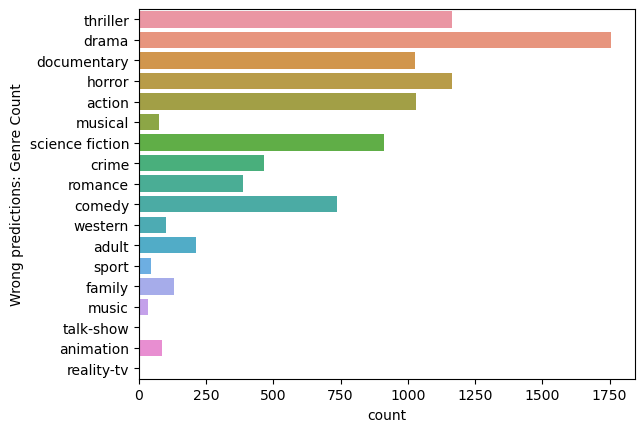

In [10]:
# Analyzing wrong predictions
import seaborn as sns
df_plot = df_matched.query('final_ored_acc == "0"')


ax = sns.countplot(data= df_plot,y = "imdb_genre1") 
ax.set(ylabel = 'Wrong predictions: Genre Count') 